In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import visdom
import numpy as np
import os
import sys
from scipy.io import savemat
import scipy.io     # used to load .mat data
from torch.utils.data import DataLoader, TensorDataset
from utils import *
#from tqdm import tqdm
import cv2
import pytorch_ssim
from image_process import MetaShape
import random
import argparse
import os
import sys
import torch
import json
from utils import Params, evaluate_forward_dataset, evaluate_tandem_accuracy,evaluate_tandem_prediction, evaluate_vae_GSNN_accuracy, evaluate_cGAN_accuracy
from net.ArbitraryShape import GeneratorNet, SimulatorNet, SimulatorNet_new, SimulatorNet_new_linear, SimulatorNet_small, InverseNet, InverseNet_new, cVAE_GSNN, cVAE_hybrid, TandemNet, cGAN
from datasets import get_dataloaders, SiliconSpectrum
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

from sklearn.metrics import r2_score

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# define some functions 


def sharp_image(image, cut_off = 0.5, del_roudn = 0):
    # binarize a generated image, use the cut_off 0.5 for [0,1]
    # image size: 64*64

    image_sharp = image.copy()
    image_sharp[image_sharp<cut_off] = 0
    image_sharp[image_sharp>=cut_off] = 1

    if del_roudn==1:
        image_sharp[0,:]=0
        image_sharp[63,:]=0
        image_sharp[:,0]=0
        image_sharp[:,63]=0

    return image_sharp


def image_area(img):
    # calculate the area of a binarized image by counting all the 1 
    # make sure all the elements of images are [0,1]
    # image size: 64*64

    return np.sum(img)

def compute_edge(images, H=64, W=64):
    # compute the gradient of a images 
    # input: binarized images [0,1]
    # ref: https://www.codingame.com/playgrounds/38470/how-to-detect-circles-in-images
    # return: the length of edge; the coordinates of edges, the image contains edges

    images_fill = np.zeros([H+2, W+2])
    images_fill[1:H+1, 1:W+1] = images
    images_edge = np.zeros([H, W])

    for i in range(1,(H+1),1):
        for j in range(1, (W+1), 1):
            temp_1 = images_fill[i,j]
            temp_2 = images_fill[i,j+1]
            temp_3 = images_fill[i+1,j]
            if (temp_2-temp_1 ==1.0) :
                images_edge[i, j+1] = 1.0
            elif temp_2-temp_1 == -1.0 :
                images_edge[i,j] = 1.0
            if (temp_3-temp_1 == 1.0) :
                images_edge[i+1, j] = 1.0
            elif temp_3-temp_1 == -1.0 :
                images_edge[i,j] = 1.0
            
    edge = []
    for i in range(H):
        for j in range(W):
            if images_edge[i,j] == 1.0:
                edge.append([i,j])
    
    edges_len = np.sum(images_edge)

    return edges_len, edge, images_edge


def irre_cal(edges):
    # calculate the irregularity rate 
    center = np.average(edges, axis=0)
    dis = []
    for [i,j] in edges:
        dis.append(np.sqrt((i-center[0])**2+(j-center[1])**2))

    
    return (np.max(dis)-np.min(dis))/np.average(dis)


def circle_rate(edges_len, image_area):
    # combine together and return 2 irregularity
    # image: [0,1]
    # output: 

    return (edges_len/(2*np.pi))**2/((image_area+1)/np.pi)





# Forward model


Val loss 0.0007858651224523783
Dataset for TE + TM modes.
Spectrum RMSE loss is: 0.000796.
Spectrum MSE loss (based on forward model) is: 0.0282097.


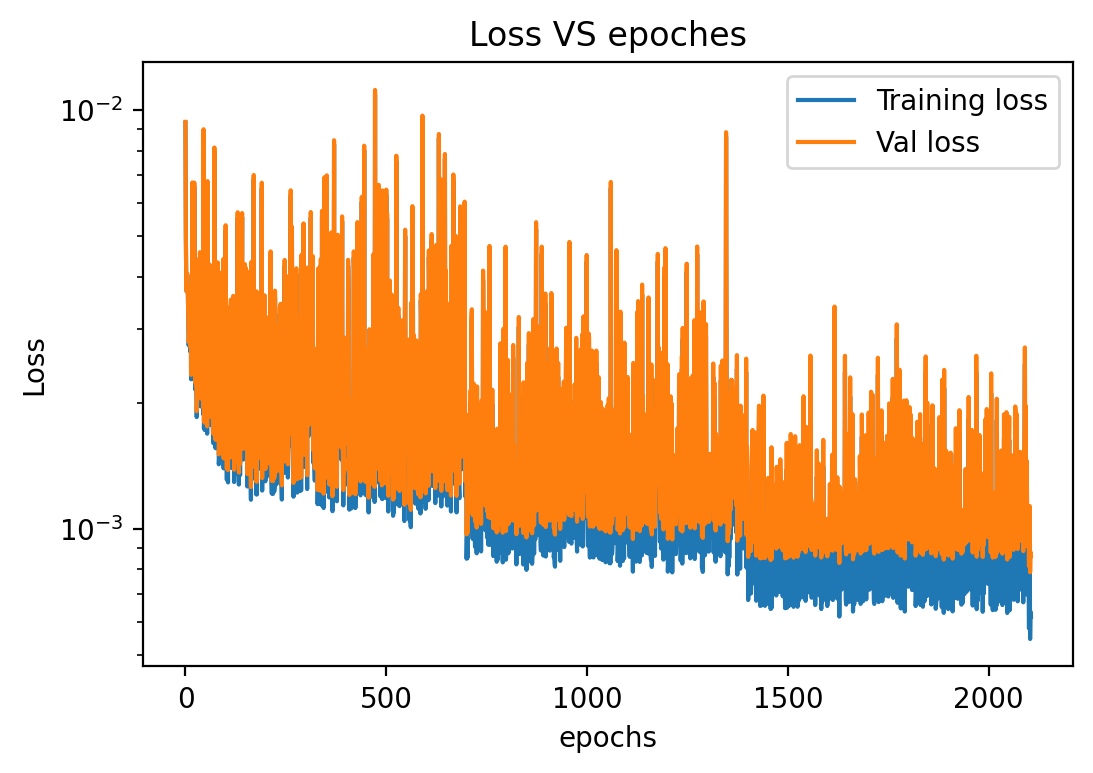

In [3]:
# For TEM mode:
forward_path =  './models/examples/forward_new_linear_TEM_depth_16_batch_1024_lr_0.0005_Step_decay_0.5_5000_700_layers_[1, 1]_kernel_9_trained.pth'

loss = torch.load(forward_path)['loss_all']
epoch = torch.load(forward_path)['epoch']
configs = torch.load(forward_path)['configs']
print('Val loss', loss[1,epoch])

fig = plt.figure(dpi=200)
fig.set_size_inches(6,4)
plt.plot(range(epoch), loss[0,:epoch], label = 'Training loss')
plt.plot(range(epoch), loss[1,:epoch], label = 'Val loss')
plt.rcParams['font.size'] = '10'
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss VS epoches')
plt.legend()

forward_model = SimulatorNet_new_linear(spec_dim=configs.spec_dim, d=configs.net_depth, thickness = configs.layers, k_size = configs.k_size, k_pad = configs.k_pad).to(DEVICE)
forward_model.load_state_dict(torch.load(forward_path)['model_state_dict'])
train_loader, val_loader, test_loader = get_dataloaders(configs.batch_size, en=1,mode=configs.spec_mode)
gap_raw, spectrum_raw, shape_raw, spectrum_pred = evaluate_forward_dataset(forward_model, test_loader.dataset, show=1)

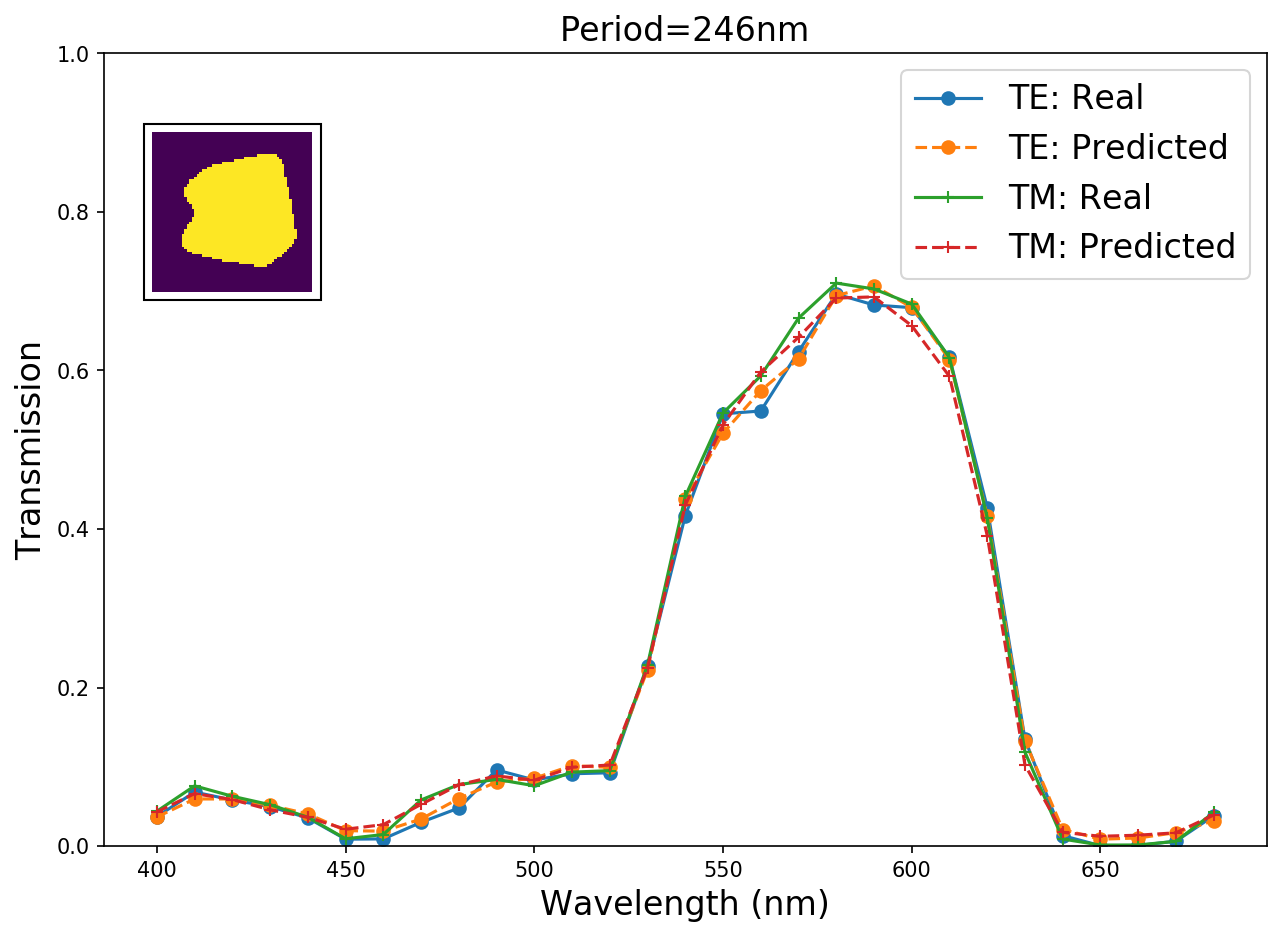

In [38]:
# show the lpredicted spectrum

T = 2376  # T=3317, 2376, 4976, 1867, 3320

size = 16
wave = np.linspace(400, 680, 29)
imagebox = OffsetImage(shape_raw[T,0,:,:], zoom=1.2)


fig, ax = plt.subplots(figsize=[10,7], dpi=150)


plt.plot(wave, spectrum_raw[T,:29], linestyle = 'solid', marker='o' , label = 'TE: Real')
plt.plot(wave, spectrum_pred[T,:29],  linestyle = 'dashed', marker='o', label = 'TE: Predicted')
plt.plot(wave, spectrum_raw[T,29:], linestyle = 'solid', marker='+' , label = 'TM: Real')
plt.plot(wave, spectrum_pred[T,29:],  linestyle = 'dashed', marker='+', label = 'TM: Predicted')

ab = AnnotationBbox(imagebox, (420, 0.8))
ax.add_artist(ab)

plt.xlabel('Wavelength (nm)', fontsize = size)
plt.ylabel('Transmission', fontsize = size)
plt.ylim([0.0, 1.0])
plt.title('Period={:d}nm'.format(int(gap_raw[T])), fontsize = size)
plt.legend(loc = 'upper right', fontsize = size)
plt.show()


# Tandem network

Val loss -0.02950206585228443
Dataset for TE + TM modes.
Loss based on the evaluating forward model
Spectrum RMSE loss (based on forward model) is: 0.002036.
Spectrum MSE loss (based on forward model) is: 0.0451237.


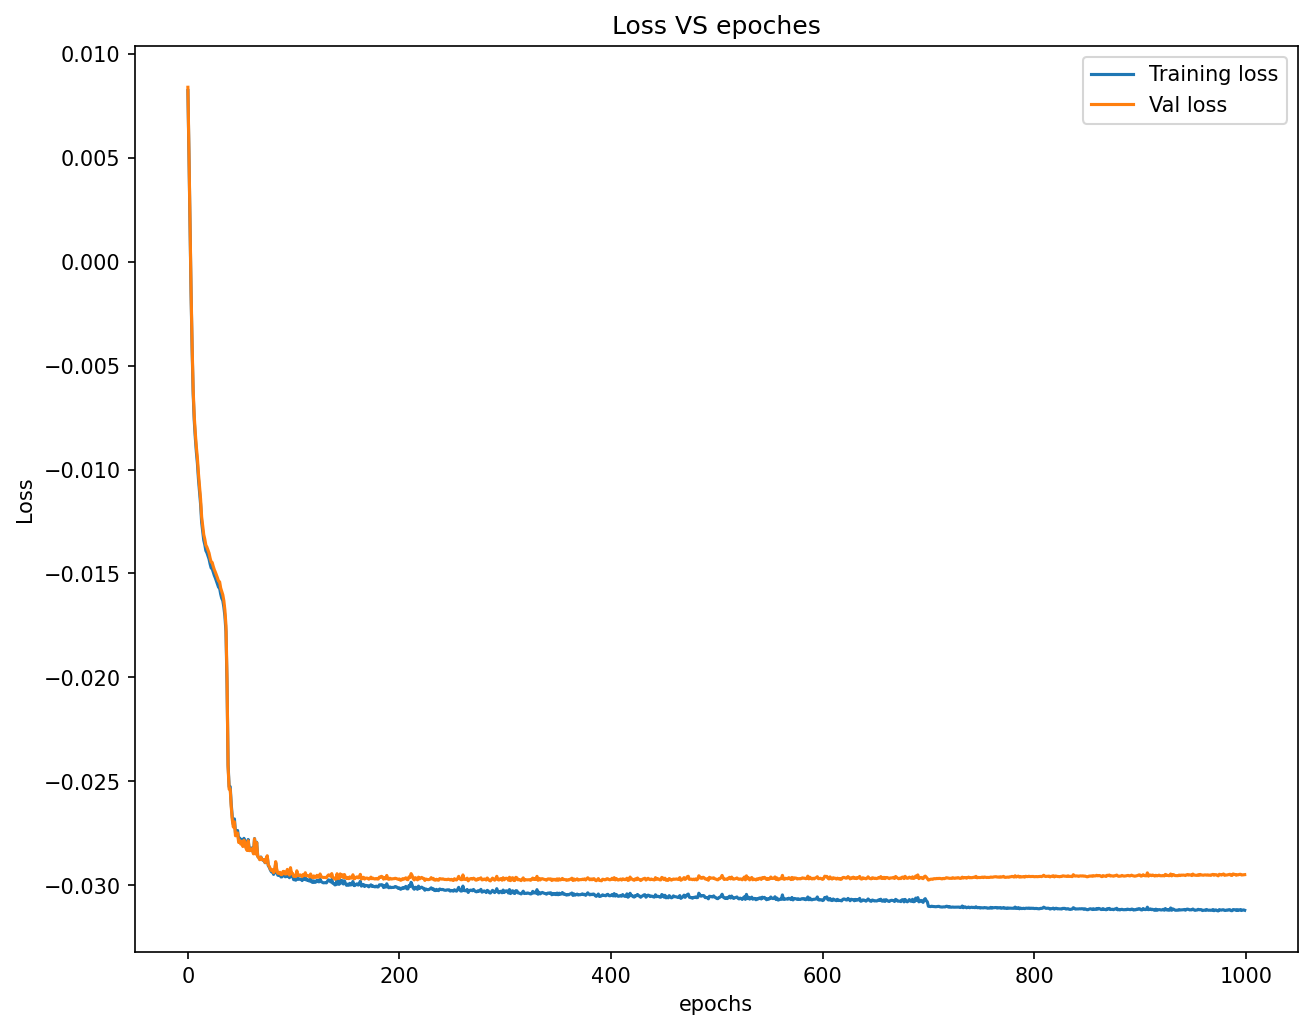

In [4]:
# For TEM mode:
# val loss: 0.001799 RMSE: 0.0424129
tandem_path =   './models/examples/tandem_new_linear_TEM_depth_16_batch_256_lr_0.0001_Step_decay_0.5_5000_700_kernel_3_alpha_0.05_trained_Num_42.pth'
tandem_path = './models/trained/tandem_new_linear_TEM_depth_16_batch_256_lr_0.0001_Step_decay_0.5_5000_700_kernel_3_alpha_0.05_trained_Num_123_temp.pth'

loss = torch.load(tandem_path)['loss_all']
epoch = torch.load(tandem_path)['epoch']
configs = torch.load(tandem_path)['configs']
print('Val loss', loss[1,epoch])

fig = plt.figure(dpi=150)

plt.plot(range(epoch), loss[0,:epoch], label = 'Training loss')
plt.plot(range(epoch), loss[1,:epoch], label = 'Val loss')
fig.set_size_inches(10,8)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss VS epoches')
plt.legend()



# For TEM modes
training_path =  './models/examples/forward_new_linear_TEM_depth_16_batch_1024_lr_0.0005_Step_decay_0.5_5000_700_layers_[1, 1]_kernel_9_trained.pth'
configs_train = torch.load(training_path)['configs']
eval_path =  './models/examples/forward_new_linear_TEM_depth_12_batch_1024_lr_0.0005_Step_decay_0.5_5000_700_layers_[1, 1]_kernel_9_trained.pth'
configs_eval = torch.load(eval_path)['configs']


forward_model = SimulatorNet_new_linear(spec_dim=configs_train.spec_dim, d=configs_train.net_depth, thickness = configs_train.layers, k_size = configs_train.k_size, k_pad = configs_train.k_pad).to(DEVICE)
#forward_model.load_state_dict(torch.load(training_path)['model_state_dict'])

forward_model_evaluate = SimulatorNet_new_linear(spec_dim=configs_eval.spec_dim, d=configs_eval.net_depth, k_size = configs_eval.k_size, k_pad = configs_eval.k_pad).to(DEVICE)
forward_model_evaluate.load_state_dict(torch.load(eval_path)['model_state_dict'])


inverse_model = InverseNet_new(spec_dim=configs.spec_dim, d=configs.net_depth, k_size = configs.k_size, k_pad = configs.k_pad).to(DEVICE)

tandem_model = TandemNet(forward_model, inverse_model)
tandem_model.load_state_dict(torch.load(tandem_path)['model_state_dict'])

train_loader, val_loader, test_loader = get_dataloaders(configs.batch_size, en=0, mode=configs.spec_mode)
print('Loss based on the evaluating forward model')
gap_raw, spectrum_raw, shape_raw, gap_pred, spectrum_pred, shape_pred = evaluate_tandem_accuracy(tandem_model, forward_model_evaluate, test_loader.dataset, show=1)



# VAE model

Dataset for TE + TM modes.
Reconstruct spectrum MSE loss 0.001652
Reconstruct spectrum RMSE loss 0.040641


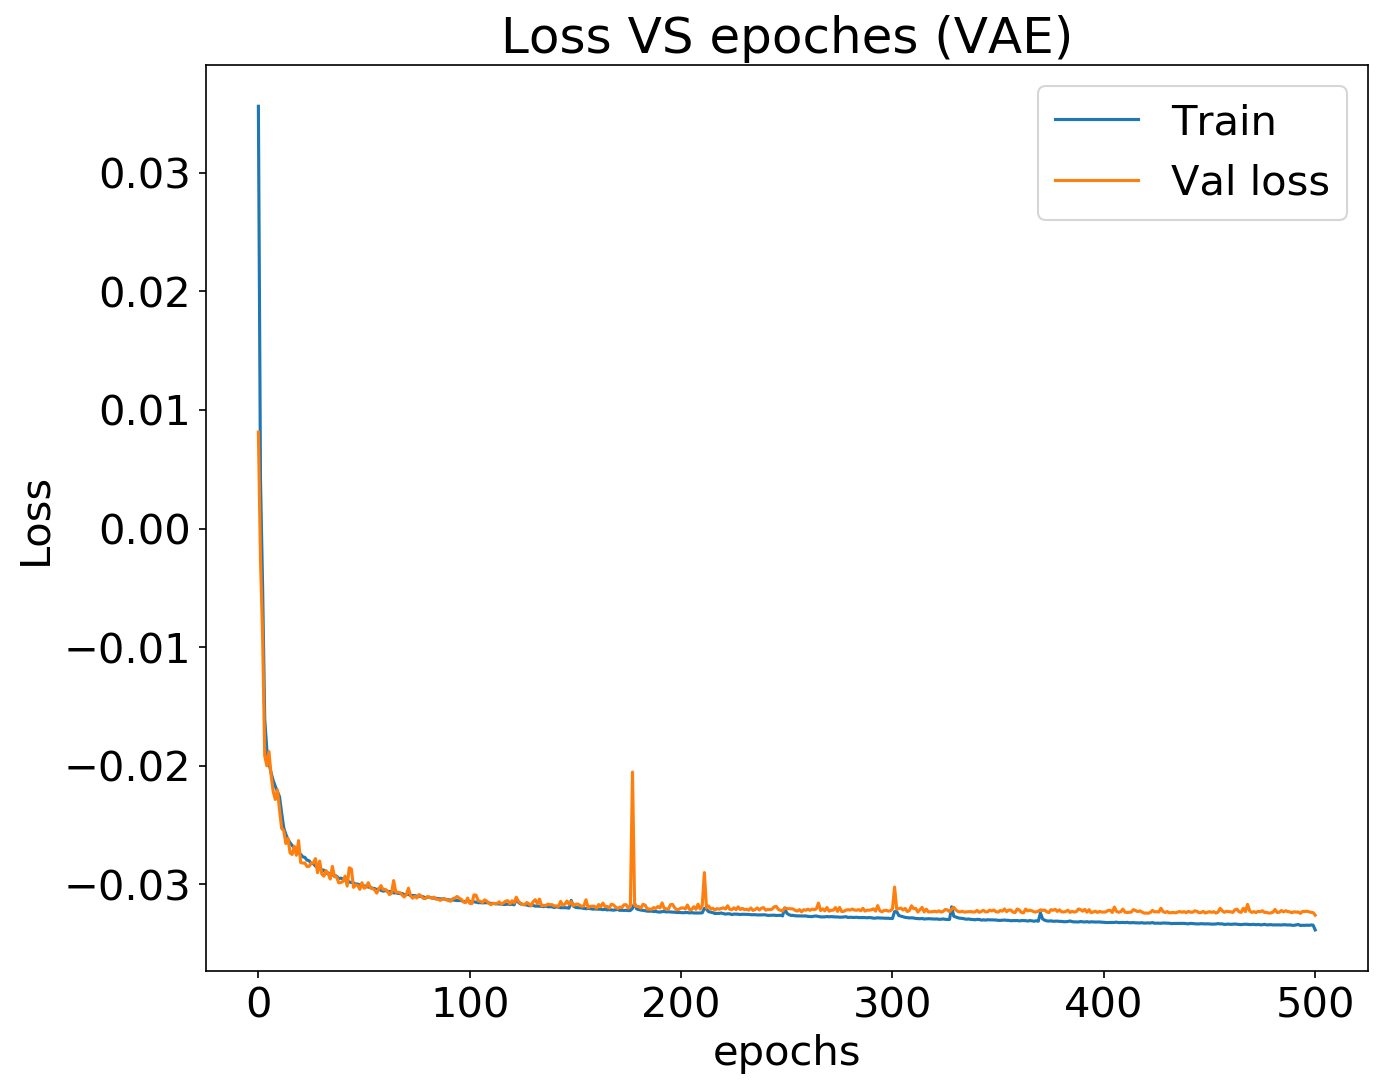

In [30]:
# For TEM modes


vae_path =  './models/examples/cvae_new_linear_TEM_depth_16_batch_256_lr_0.0001_Step_decay_0.5_5000_700_kernel_5_alpha_0.05_trained_Num_42.pth'

loss_train = torch.load(vae_path)['loss_all_train']
loss_eval = torch.load(vae_path)['loss_all_eval']
epoch = torch.load(vae_path)['epoch']
configs = torch.load(vae_path)['configs']


fig = plt.figure(dpi=150)
plt.plot(range(epoch), loss_train[:epoch, 0], label = 'Train')
plt.plot(range(epoch), loss_eval[:epoch, 0], label = 'Val loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
fig.set_size_inches(10,8)
plt.title('Loss VS epoches (VAE)')
plt.legend()



# For TEM modes
training_path =  './models/examples/forward_new_linear_TEM_depth_16_batch_1024_lr_0.0005_Step_decay_0.5_5000_700_layers_[1, 1]_kernel_9_trained.pth'
configs_train = torch.load(training_path)['configs']
eval_path =  './models/examples/forward_new_linear_TEM_depth_12_batch_1024_lr_0.0005_Step_decay_0.5_5000_700_layers_[1, 1]_kernel_9_trained.pth'
configs_eval = torch.load(eval_path)['configs']


forward_model = SimulatorNet_new_linear(spec_dim=configs_train.spec_dim, d=configs_train.net_depth, thickness = configs_train.layers, k_size = configs_train.k_size, k_pad = configs_train.k_pad).to(DEVICE)
forward_model.load_state_dict(torch.load(training_path)['model_state_dict'])

forward_model_evaluate = SimulatorNet_new_linear(spec_dim=configs_eval.spec_dim, d=configs_eval.net_depth, k_size = configs_eval.k_size, k_pad = configs_eval.k_pad).to(DEVICE)
forward_model_evaluate.load_state_dict(torch.load(eval_path)['model_state_dict'])


vae_model = cVAE_GSNN(spec_dim=configs.spec_dim, latent_dim=configs.latent_dim, d=configs.net_depth, thickness=configs.layers, k_size=configs.k_size, k_pad=configs.k_pad).to(DEVICE)

model = cVAE_hybrid(forward_model, vae_model).to(DEVICE)
model.load_state_dict(torch.load(vae_path)['model_state_dict'])


train_loader, val_loader, test_loader = get_dataloaders(configs.batch_size, en=0, mode=configs.spec_mode)
gap_raw, spectrum_raw, shape_raw, gap_pred, spectrum_pred_eval, shape_pred = evaluate_vae_GSNN_accuracy(vae_model, forward_model_evaluate, test_loader.dataset, show=1)

# GAN

Dataset for TE + TM modes.
Reconstruct spectrum MSE loss 0.004049
Reconstruct spectrum RMSE loss 0.063631


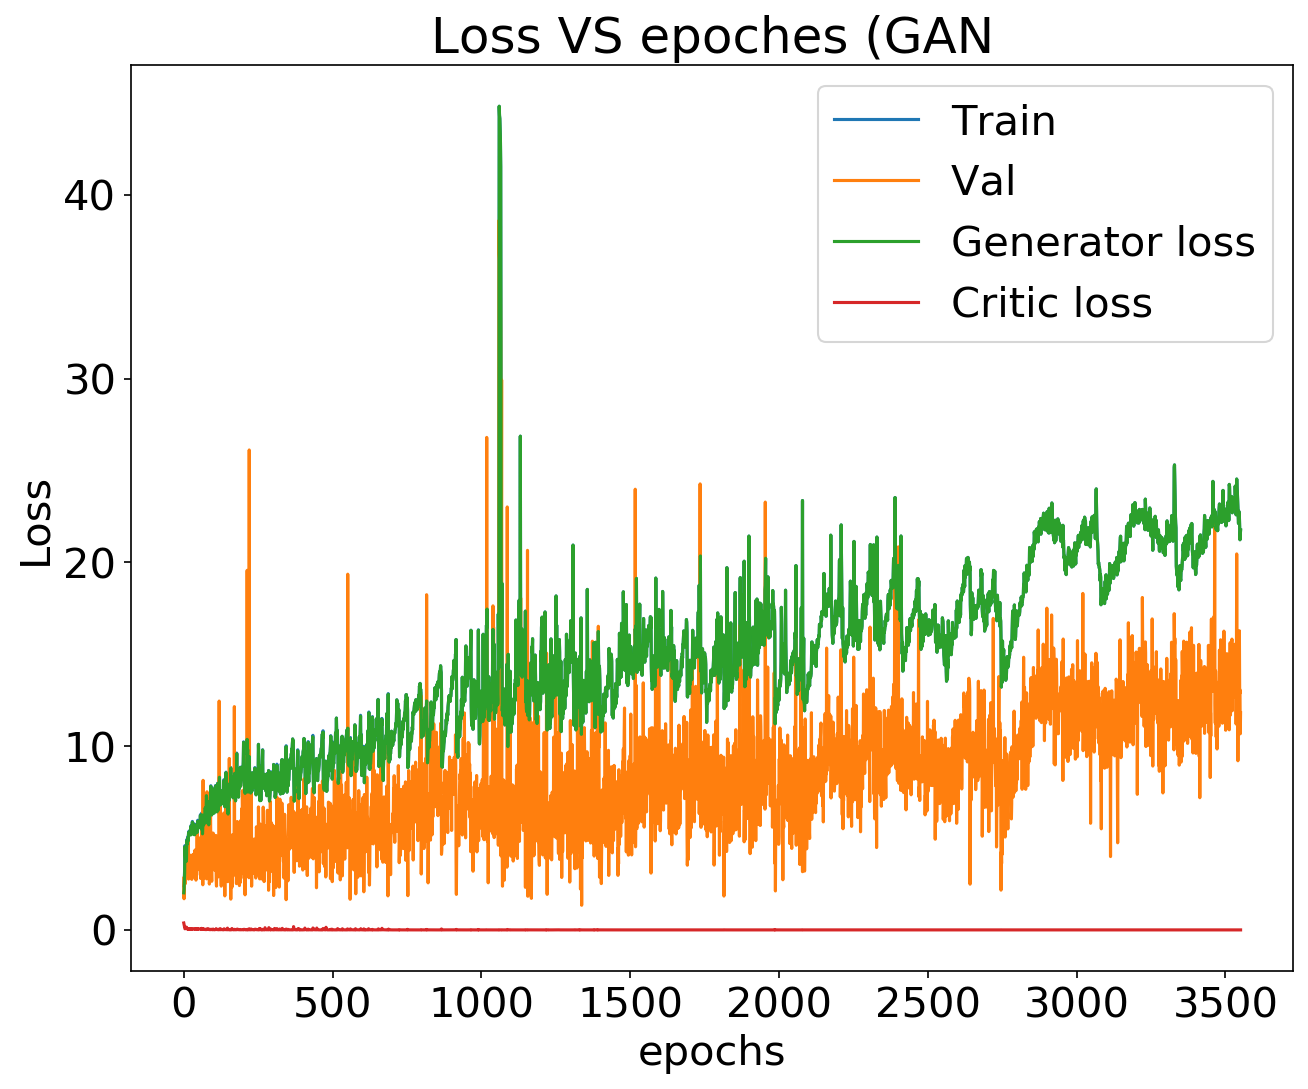

In [25]:
# For TEM modes

gan_path =  './models/examples/cgan_new_linear_TEM_depth_16_batch_256_lr_G_0.001_lr_D_0.0001_Step_decay_0.5_5000_700_kernel_5_alpha_0.05_trained_Num_42.pth'


loss_train = torch.load(gan_path)['loss_all_train']
loss_eval = torch.load(gan_path)['loss_all_eval']
epoch = torch.load(gan_path)['epoch']
configs = torch.load(gan_path)['configs']

fig = plt.figure(dpi=150)
fig.set_size_inches(10,8)
plt.plot(range(epoch), loss_train[:epoch, 0], label = 'Train')
plt.plot(range(epoch), loss_eval[:epoch, 0], label = 'Val ')
plt.plot(range(epoch), loss_train[:epoch, 1], label = 'Generator loss')
plt.plot(range(epoch), loss_train[:epoch, 2], label = 'Critic loss ')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss VS epoches (GAN')
plt.legend()



eval_path =  './models/examples/forward_new_linear_TEM_depth_12_batch_1024_lr_0.0005_Step_decay_0.5_5000_700_layers_[1, 1]_kernel_9_trained.pth'
configs_eval = torch.load(eval_path)['configs']

forward_model_evaluate = SimulatorNet_new_linear(spec_dim=configs_eval.spec_dim, d=configs_eval.net_depth, k_size = configs_eval.k_size, k_pad = configs_eval.k_pad).to(DEVICE)
forward_model_evaluate.load_state_dict(torch.load(eval_path)['model_state_dict'])

gan_model = cGAN(img_size=64, gap_dim=1, spec_dim=configs.spec_dim, noise_dim=configs.noise_dim, d=configs.net_depth, thickness=configs.layers, k_size=configs.k_size, k_pad=configs.k_pad).to(DEVICE)
gan_model.load_state_dict(torch.load(gan_path )['model_state_dict'])


train_loader, val_loader, test_loader = get_dataloaders(configs.batch_size, en=0, mode=configs.spec_mode)

gap_raw, spectrum_raw, shape_raw, gap_pred, spectrum_pred_eval, shape_pred = evaluate_cGAN_accuracy(gan_model, forward_model_evaluate, test_loader.dataset, configs, show=1)
